<a href="https://colab.research.google.com/github/MASHAR27/BCHACKS2024/blob/main/generate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget file.weasoft.com/music.mod

--2024-01-28 17:16:31--  http://file.weasoft.com/music.mod
Resolving file.weasoft.com (file.weasoft.com)... 149.28.13.194
Connecting to file.weasoft.com (file.weasoft.com)|149.28.13.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101864911 (97M) [application/xml-dtd]
Saving to: ‘music.mod’

music.mod           100%[===================>]  97.15M  58.4MB/s    in 1.7s    

2024-01-28 17:16:33 (58.4 MB/s) - ‘music.mod’ saved [101864911/101864911]



In [2]:
import torch
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

DIM = 512
import math
import torch.nn as nn
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)].to(device)
        return x
#https://pytorch.org/tutorials/beginner/transformer_tutorial.html

class Music(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.pos = PositionalEncoding(DIM, max_len=201)#torch.nn.Embedding(200, DIM).to(device)
    self.projection = torch.nn.Embedding(128, DIM).to(device)
    self.trans = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(DIM, 16, batch_first=True), 8).to(device)
    self.output = torch.nn.Linear(DIM, 128).to(device)
  def forward(self, x):
    #pos = self.pos(torch.arange(0,200).to(device))
    feature = self.projection(x)
    feature = self.pos(feature)
    feature = self.trans(feature, mask=torch.nn.Transformer.generate_square_subsequent_mask(200), is_causal=True)
    return self.output(feature)
model = Music()
model = torch.load("music.mod", map_location=device)

In [24]:
inp = torch.tensor([[0]]).to(torch.int32)
t = 1.3
for i in range(100):
  p = torch.nn.functional.softmax(model(inp)[0][-1]/t).detach().numpy()
  out = np.random.choice(np.arange(128), p=p)
  out = torch.tensor(out).unsqueeze(-1).unsqueeze(-1)
  inp = torch.concat((inp, out), dim=-1)

<ipython-input-24-5b0483d78e4f>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p = torch.nn.functional.softmax(model(inp)[0][-1]/t).detach().numpy()


In [26]:
" ".join([str(i) for i in inp.detach().numpy()[0]])

'0 71 66 66 71 72 71 31 36 36 42 78 46 63 66 57 61 69 35 54 61 61 61 71 39 42 66 38 42 61 39 54 43 42 54 3 59 67 55 43 47 54 4 54 42 4 59 59 42 42 83 71 66 36 83 59 66 31 38 47 36 64 28 54 66 36 39 28 35 47 4 28 66 59 41 49 38 59 54 59 54 64 46 52 42 36 39 4 42 4 36 46 47 59 4 39 54 59 64 48 4'

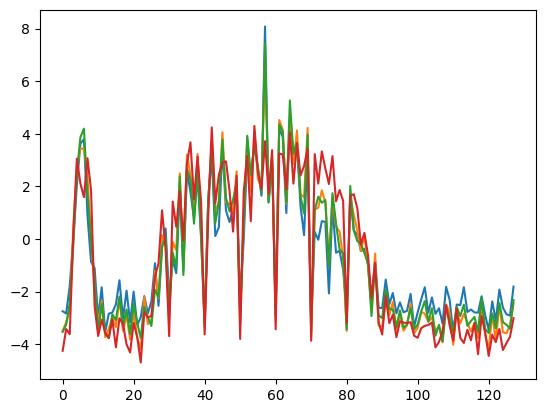

In [12]:
import pylab
pylab.plot(model(inp)[0][-1].detach())
pylab.plot(model(inp[:,:3])[0][-1].detach().numpy())
pylab.plot(model(inp[:,:5])[0][-1].detach().numpy())
pylab.plot(model(inp[:,:1])[0][-1].detach().numpy())


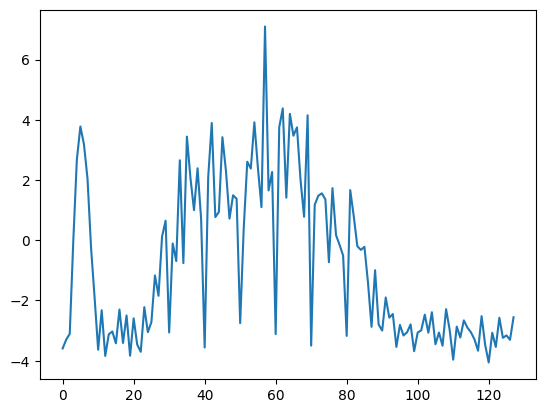

In [10]:
import pylab
pylab.plot(model(inp[:,:3])[0][-1].detach().numpy())